Source of data: https://data.stackexchange.com/stackoverflow/query/edit/960504  
SQL request: SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2016' AND Tags IS NOT NULL AND Score > 10

good ressource: [here](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

01. <a href="#1.-Import-and-cleaning-data">Import and cleaning data</a>  
    1.1 <a href="#1.1-Tag-processing">Tag processing</a>  
    1.2 <a href="#1.2-Corpus-processing">Corpus processing</a>  
    1.3 <a href="#1.3-Feature-engineering">Feature engineering</a>  
02. <a href="#2.-Unsupervised-learning">Unsupervised learning</a>  
    2.1 <a href="#2.1-LDA:-LatentDirichletAllocation">LDA: LatentDirichletAllocation</a>  
    2.2 <a href="#2.2-NMF:-Negative-Matrix-Factorisation">NMF: Negative Matrix Factorisation</a>  
03. <a href="#5.-supervised-models">supervised models</a>


## 1. Import and cleaning data
The first cleaning consist mainly on removing some specific characters (":", "*", "[", ...) and html/xml tags.

In [332]:
# import data
import pandas as pd
import nltk   # Natural Language Toolkit

text = pd.read_csv("QueryResults.csv", index_col=0)
text_df = text.sample(10000)   # to limit processing time
text_df.head(5)

,Body,Title,Tags,LastActivityDate,Score
Id,,,,,
27164404,<p>I know how to do it in Mocha but want to kn...,Test if a promise is resolved or rejected with...,<javascript><node.js><jasmine><promise>,2018-06-27 05:57:41,25
18295802,"<p>Before you downvote and mark as duplicate, ...",How to make EditText not focused when creating...,<java><android><focus><android-edittext>,2018-11-09 07:57:00,61
9361870,<p>I need to get an accurate measurement of al...,Android: How to get accurate altitude?,<android><gps><location><altitude>,2018-11-02 10:42:09,42
37609356,"<p>Recently updated to Windows 10, installed U...",Windows 10 - Bash (Ubuntu) SU (Root Password),<bash><windows-10><windows-subsystem-for-linux>,2016-06-18 22:20:08,37
3797746,<p>I want to split a sentence into a list of w...,How to do a Python split() on languages (like ...,<python><string><unicode><nlp><cjk>,2018-10-23 12:03:26,14


In [85]:
# Merge Body and Title columns
corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]
corpora.head()

Id
553185      Cache VS Session VS cookies?<p>What are the do...
35654569    Powershell: If strings starts with<p>is there ...
34954771    Multiple Aggregate operations on the same colu...
19511797    Remove duplicates in an array without changing...
2178416     Using 'starts with' selector on individual cla...
dtype: object

In [195]:
# clean text function
import re   # Regular expression library

def cleantext(raw_text):
    """clean raw text: 
           1. remove markups
           2. remove some special characters
           3. lower all"""
    
    #1. remove markups
    cleanr = re.compile('<.*?>')  
    cleantext = re.sub(cleanr, ' ', raw_text)
    
    #2. remove special characters
    element2remove = [r"\.\s", r'"', r"'", r"\!", r"\?", r"\,",
                      r"\:", r"\(", r"\)", r"\n", r"\*", r"\]", r"\[", "&nbsp;",
                      "&lt;", "&amp", r"\//", "=", r"\{", r"\}", r"\&gt;", ";", r"\%"]                   
    for e in element2remove:
        cleantext = re.sub(e, ' ', cleantext)
        
    #3. lower all (remove Capital letters)   
    cleantext = cleantext.lower() 
    
    return cleantext

In [196]:
corpora = corpora.apply(cleantext)
corpora.iloc[0]

'cache vs session vs cookies  what are the do s and don ts about cache vs session vs cookies     for example   i m using session variables a lot and sometimes have problems in a booking-application when users start to order products and then go to lunch and come back some hours later and continue the booking i store the booking in the session until the user confirms or aborts the booking so i don t need to talk to the database and handle halfway bookings in the database when users just click the x in the browser and never comes back    should i instead use cache or cookies or some combination for this      also when there is some error in the app  the session-object resets itself and i get more problems because of that     i m mostly doing desktop-programming and feel i lack lots of knowledge here so anyone who can expand on where to use cache  session  cookies  or db  would be appreciated     edit   from the answers it seems that a combination of db and cookies is what i want         

### 1.1 Tag processing
In this section we will clean and explore the tag columns.

In [88]:
# clean tags
tags = text_df.loc[:, "Tags"]

def cleantags(tags):
    """clean raw tags"""
    #remove markups
    tags = tags.replace("><", ' ')
    tags = tags.replace("<", '')
    tags = tags.replace(">", '')
    tags = tags.lower()  # remove capital letters
    return tags

tags = tags.apply(cleantags)
tags.head()

Id
553185      asp.net session cookies state-management
35654569          powershell if-statement startswith
34954771               apache-spark apache-spark-sql
19511797                      java arrays duplicates
2178416                                       jquery
Name: Tags, dtype: object

In [89]:
# lists of tags
all_tags = []       # list of all tags
primary_tags = []   # list of first tags (= the most relevent for each docs)
document_tags =  [] # "list of list" of tags for each document
for line in tags:
    tag = line.split()
    primary_tags.append(tag[0])
    document_tags.append(tag)
    for w in tag:
        all_tags.append(w)
        
primary_tags = nltk.FreqDist(primary_tags)   # ~ dict type
all_tags = nltk.FreqDist(all_tags)           # ~ dict type

In [90]:
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])
cum_sum = df_1["freq_all"].cumsum()  #


In [91]:
cum_sum.tail()

5414    30155
5415    30156
5416    30157
5417    30158
5418    30159
Name: freq_all, dtype: int64

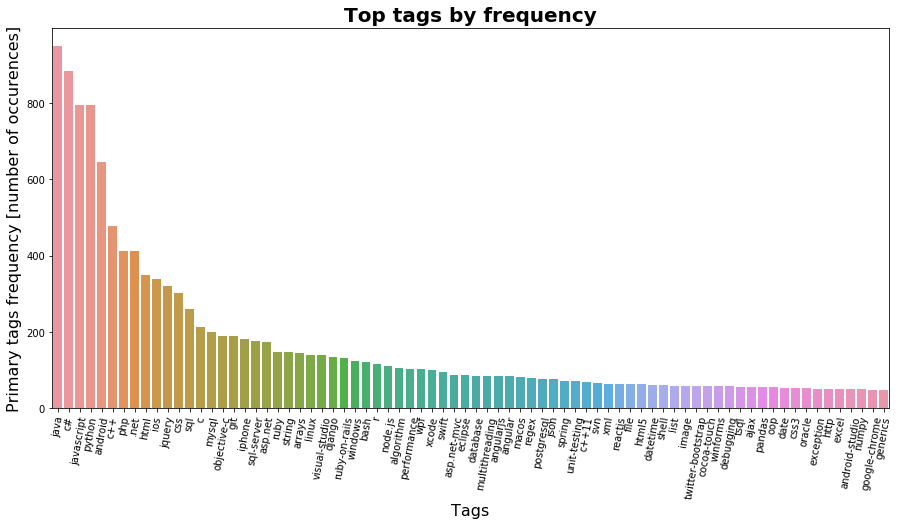

In [92]:
# most common tags plot
import matplotlib.pyplot as plt
import seaborn as sns

# inputs
top_n = 75
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])
df_2 = pd.DataFrame(primary_tags.most_common(), columns=["tags","freq_primary"])  
df = pd.merge(df_1, df_2, how="left" )

# plot
plt.figure(figsize=(15,7))
plt.title("Top tags by frequency", fontweight="bold", size=20)
sns.barplot(y= "freq_all", x= "tags", data= df.loc[0:top_n, :], label="Total")
plt.xticks(rotation=80, size=10)
plt.xlabel("Tags", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()

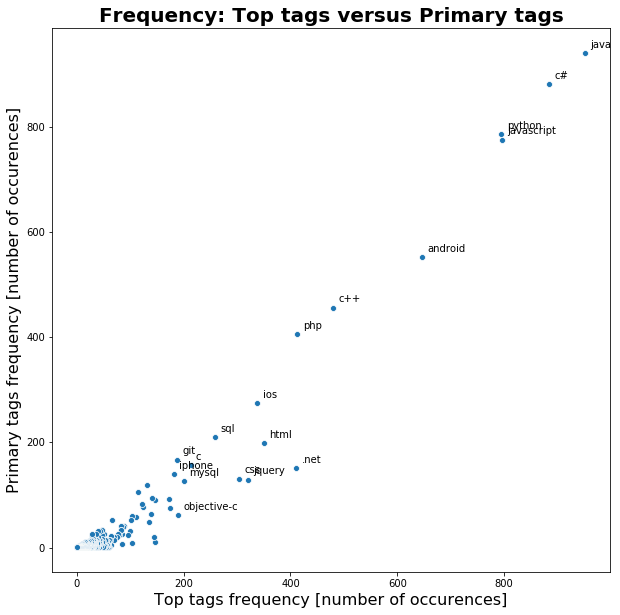

In [93]:
# relation in-beetwee frequency on top tags and primary tags 
plt.figure(figsize=(10, 10))
plt.title("Frequency: Top tags versus Primary tags", fontweight="bold", size = 20)
sns.scatterplot(x="freq_all", y="freq_primary", data=df)
# plt.scatter(x="freq_all", y="freq_primary", data=df, label="Total",marker="+", s=75)

for i in range(0,18):
    plt.annotate(df.loc[i,"tags"],
                 (df.loc[i,"freq_all"]+10, df.loc[i,"freq_primary"]+10),
                 size=10)

plt.xlabel("Top tags frequency [number of occurences]", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()  

Clear correlation from primary tags freq and all tags frequency. For the rest we will select the top 150 tags (as it decreases very slowly in this area)

In [94]:
# creaton of top tag list
top_n = 150
top_t = list(df.loc[0:top_n-1, "tags"])

# Extra infos
count_top = df.loc[0:top_n, "freq_all"].sum()
count_all = df["freq_all"].sum()
fract_t = round(top_n/len(df),2)*100
fract_v = round(count_top/count_all,3)*100
print("The top {} tags ({}% of the tag population)\
represent {}% in term of volume/occurences.".format(top_n, fract_t, fract_v))

The top 150 tags (3.0% of the tag population)represent 51.0% in term of volume/occurences.


### 1.2 Corpus processing
In this section we will clean and explore the corpus (body columns).

In [257]:
# Part of Speech Tagging
import nltk
from nltk.tokenize import PunktSentenceTokenizer   # already train sentence tokensier
from nltk.corpus import stopwords
import numpy as np

# --------------------------------------------------------------------------------

# standard stopwords list from nltk library
stopwords = set(stopwords.words("english"))

# updated with some specific words
stopwords.update(["p","/p","way","=","something", "anyone", "possible", "good", "example",
                 "question", "solution", "able", "different", "first", 'following',
                  "anything", 'help', 'thing','sure', 'many', 'lot', 'much', "several",
                  "wrong", "right", "idea", "easy", "everything", "difference", "|",
                 "certain", "kind", "great", "nothing", "answer", "please", "little",
                 "/", r"\&gt", "+", "..", "specific", "code", "new", "name",
                 "error", "use", "file", "work", "value", "ok", "true"])

def process_content(text_body, stopwords):
    """
    Tokenize a text ('text_body') by words and keep the nouns(NN) and adjective or numeral, ordinal (JJ) 
    then remove stop words ('stopwords').
    Inputs:
        - text_body: string
        - stopwords: list of string
    Outputs:
        - return a list of words selection
        """
    
    tokenizer = PunktSentenceTokenizer()
    tokenized = tokenizer.tokenize(text_body)
    all_nouns = []   
    for sentence in tokenized:
        # words = nltk.word_tokenize(sentence)
        words = sentence.split()
        # get the information of the word (noune, verb,etc..)
        tagged = nltk.pos_tag(words)  
        for w in tagged:
            if ((w[1] == "NN")or(w[1] == "JJ")) and (w[0] not in stopwords):
                all_nouns.append(w[0])
    return all_nouns

In [198]:
# list of processed words
all_words = []
for body in corpora:
    tokenized_body = process_content(body, stopwords)
    for w in tokenized_body:
        all_words.append(w)
all_words = nltk.FreqDist(all_words)   # ~ dict type
print("{} words have been extracted".format(len(all_words)))

55661 words have been extracted


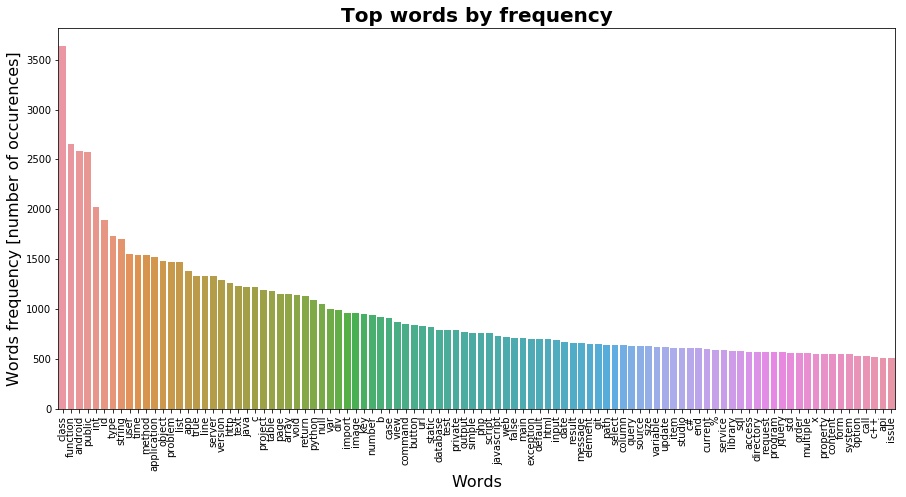

In [97]:
# most frequent words
# inputs
top_n = 100
df = pd.DataFrame(all_words.most_common(top_n), columns=["words","freq"])

# plot
plt.figure(figsize=(15,7))
plt.title("Top words by frequency", fontweight="bold", size=20)
plt.xticks(rotation=90, size=10)
sns.barplot(y="freq", x="words", data=df.loc[0:top_n, :], label="Total");
plt.xlabel("Words", size=16)
plt.ylabel("Words frequency [number of occurences]", size=16)
plt.show()

In [98]:
".net" in all_words

True

In [99]:
# ### TESt Tokenisation
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# text1 = "ou la méthode non supervisée utilisée) et TF-IDF (pendant la soutenance ou en question) .net"
# text2 = "tokeniser en prenant en compte les particularités des données (indice : attention à d3.js et c++ !)"

# tok = process_content(text2, stopwords)

# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
#                                            stop_words=stopwords)
# tfidf = tfidf_vectorizer.fit_transform(tok)

In [100]:
# Build vocabulary dict based on the most fequent words
number_of_top_words = 500
top_w = list(zip(*all_words.most_common(number_of_top_words)))[0]

# add top tags to this list
top_w = set(list(top_w) + list(top_t))
len(top_w)

594

### 1.3 Feature engineering
In this section, based on our corpus and list of most commons words, we will create new features that can be used as input for our models:
- TF Term Frequency table: for each documents (row) we will compute the frequency of the most frequent words (columns)
- TF-IDF Term Frequency - Inverse Document Frequency: The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This help to reduce the importance of the very commons words. More information [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
First, to build those tables we need to select wich feature/words that would be used as input. For this we will run several times:
    1. Create a vocabulary list
    2. Create TF and TF-IDF Table 
    3. Run the LDA model
    4. Model score evaluation  

On each loops we will change the initial vocabulary list, and see the impact on the final scoring.  
    

 

In [101]:
# formating input for the vocabulaty list
def vocabulary(all_words, all_tags, Nw, Nt):
    """ return a dictionary of vocabulary. It merges the top Nw words from all_words
    with the top Nt from all_tags. This format is needed as input of nltk vectoriser"""
    top_w = list(zip(*all_words.most_common(Nw)))[0]
    top_t = list(zip(*all_tags.most_common(Nt)))[0]
    # add top tags to this list
    top_w = set(list(top_w) + list(top_t))

    # formating: list of for for vectorized input
    return dict(zip(top_w, range(0, len(top_w))))

In [104]:
document_tags

[['asp.net', 'session', 'cookies', 'state-management'],
 ['powershell', 'if-statement', 'startswith'],
 ['apache-spark', 'apache-spark-sql'],
 ['java', 'arrays', 'duplicates'],
 ['jquery'],
 ['android', 'python', 'matplotlib', 'tablet', 'pydroid'],
 ['jquery', 'jquery-ui'],
 ['python', 'linux', 'ms-word'],
 ['vba', 'variable-assignment'],
 ['jquery', 'asp.net', 'html-table'],
 ['r', 'ggplot2'],
 ['css'],
 ['javascript', 'ajax'],
 ['asp.net-mvc', 'datetime', 'localization', 'formatting', 'model-binders'],
 ['spring', 'spring-security'],
 ['java', 'maven-2', 'intellij-idea'],
 ['c++', 'c', 'volatile', 'compiler-optimization'],
 ['iphone', 'unit-testing', 'xcode'],
 ['javascript', 'ios', 'pushstate', 'wai-aria', 'voiceover'],
 ['c#', 'design-patterns', 'entity-framework'],
 ['javascript', 'html', 'css'],
 ['lua', 'concatenation', 'lua-table'],
 ['ruby', 'build', 'rake'],
 ['c#', 'dictionary'],
 ['sqlite'],
 ['angularjs', 'angularjs-directive', 'javascript', 'javascript-framework'],
 ['c#'

In [77]:
# Functions used for the scoring evaluations
# Note: The words return here are the top X based on the number of occurence
# could be better the have the top percentage compare to the complete Corpus

def display_topics2(model, feature_names, no_top_words=25):
    """create a panda data frame of the top words present in each topics.
    inputs: 
        - model: fitted model, from where we will extract the results (numeric)
        - feature_names: list of string (words used in the model)
        - no_top_words: int, the number of top words per topics we want to extract
    output:
        - Pandas data frame 
        """
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict["Topic%d" % (topic_idx)] = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(word_dict).T

def topic_score(model, vectorized_input, feature_names, top_t, document_tags):
    """The scoring function is design for the purpose off assessing the quality of the predicted tag
    in the context of tags suggestion. For tis we will compute the ratio of real tags words present
    in the predicted list of tags.
    Inputs: 
        - model: fitted sklearn model, from where we will extract the results (numeric).
        - vectorized_input: tf or tf-idf vectorized input
        - feature_names: list of string (words used in the model)
        - document_tags: list of list of str, each document has a list of real tags
        - top_t: list of str, all existing tags 
    Output:
        - score: float, [0:1]
        """

    # topic df ----------------------------------------------------------------------------
    topic_df = display_topics2(model, feature_names, no_top_words=25)
    # associate each topic with a list of tags
    topics_kwords_df = (topic_df.isin(top_t)*topic_df).T
    topic2tags_d = {}
    tags_per_topic = []
    for topic in topics_kwords_df:
        tag_list = []
        for e in topics_kwords_df.loc[:, topic]:
            if e is not "":
                tag_list.append(e)
        topic2tags_d[topic] = tag_list

    # Create Document Vs Topic Matrix ------------------------------------------------------
    model_output = model.transform(vectorized_input)
    # column names
    topicnames = ["Topic" + str(i) for i in range(model.components_.shape[0])]
    # index names
    docnames = ["Post" + str(i) for i in range(vectorized_input.shape[0])]
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)

    # Tag prediction -----------------------------------------------------------------------
    treshold = 0.20
    tag_pred = []
    for post in df_document_topic.index:
        tags_post = []
        mask = df_document_topic.loc[post, :] >= treshold
        topic_pred = list(df_document_topic.loc[post, mask].index)
        for topic in topic_pred:
            tags_post = tags_post + topic2tags_d[topic].copy()
        tag_pred.append(tags_post)

    # Scoring ----------------------------------------------------------------------------------
    tag_score = []   # list of score for each document (score = ratio of real tags present in the prediction)
    for i in range(len(document_tags)):
        score = 0 
        count_e = 0
        for e in document_tags[i]:
            if e in tag_pred[i]:
                score = score + 1
            count_e = count_e + 1
        tag_score.append(round(score/count_e,2))

    return sum(tag_score)/len(tag_score)

In [76]:
# Manual grid seach on the composition of vocabulary

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import numpy as np

n_top_w = [1,50,100,300]
n_top_t = [100,150,200,300]

grid_score_lda_tf = pd.DataFrame(0, index = n_top_w, columns= n_top_t) 
grid_score_lda_tf.index.name = "n_top_w"
grid_score_lda_tf.columns.name = "n_top_t"
grid_score_lda_tfidf = grid_score_lda_tf.copy()
grid_score_nmf_tf = grid_score_lda_tf.copy()
grid_score_tfidf = grid_score_lda_tf.copy()
grid_score_nmt_tfidf = grid_score_lda_tf.copy()


for w in n_top_w:
    for t in n_top_t:

        voca = vocabulary(all_words, all_tags, w, t)
        
        # tf
        tf_vectorizer = CountVectorizer(vocabulary=voca,
                                        stop_words=stopwords)
        tf = tf_vectorizer.fit_transform(corpora)

        # tf-idf
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(vocabulary=voca,
                                           stop_words=stopwords)
        tfidf = tfidf_vectorizer.fit_transform(corpora)

        # extraction of feature names
        feature_names = tf_vectorizer.get_feature_names()     
        
        no_topics = 25  # hyperparametre (a tester)
        # Run LDA on tf
        lda_tf = LatentDirichletAllocation(n_topics=no_topics, 
                                            random_state=1).fit(tf)
        grid_score_lda_tf.loc[w, t ] = topic_score(lda_tf, tf, feature_names, top_t)

        # Run LDA on tfidf
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                            random_state=1).fit(tfidf)
        grid_score_lda_tfidf.loc[w, t ] = topic_score(lda_tfidf, tfidf, feature_names, top_t)
        
        # Run NMF on tf
        nmf_tf = NMF(n_components=no_topics, 
                     random_state=1, 
                     init='nndsvd').fit(tf)
        grid_score_nmf_tf.loc[w, t ] = topic_score(nmf_tf, tf, feature_names, top_t)
        
        # Run NMF on tfidf
        nmf_tfidf = NMF(n_components=no_topics, 
                        random_state=1, 
                        init='nndsvd').fit(tfidf)
        grid_score_nmt_tfidf.loc[w, t ] = topic_score(nmf_tfidf, tfidf, feature_names, top_t)
             
        print("loops W=",w,"  T=",t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 300


In [79]:
grid_score_lda_tf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.281971,0.293587,0.288465,0.267990
50,0.231829,0.241924,0.250867,0.234055
100,0.202075,0.230225,0.238934,0.231737
300,0.200625,0.193501,0.201804,0.209789


In [80]:
grid_score_lda_tfidf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.274717,0.294396,0.288836,0.264009
50,0.245658,0.266458,0.266104,0.245182
100,0.232528,0.250424,0.256527,0.243066
300,0.220102,0.220815,0.226201,0.231514


In [82]:
grid_score_nmt_tfidf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.111092,0.087007,0.088413,0.067507
50,0.024171,0.032613,0.025317,0.038263
100,0.026349,0.028783,0.030452,0.031888
300,0.016221,0.021647,0.021730,0.020335


In [84]:
grid_score_nmf_tf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.096497,0.101115,0.093115,0.081130
50,0.069998,0.070063,0.070374,0.061293
100,0.056009,0.057478,0.056222,0.051603
300,0.048122,0.049860,0.048501,0.047175


The best score is obtain when the vocabulary input list is a combinaison of the top 1 words and the top 150 tags. It is quite instinctive that the chance of getting a correct tags is better if from the start, we select only the tags words as feature.
import numpy as npHowever here, we might also want the futur tag recommendation engine to be able to also produce new tags (IT world is changing fast). So even if it degrade a little bit our final quality we would introduce the 50 top words from the corpus. The Best model using the standard parameters is LDA combined with Tf-idf table. Note that NMF might perform better if we tune the parameters. However for simplicity, we will keep the LDA model with tfidf and try to optimise it.

In [110]:
len(corpora)

10000

In [118]:
import numpy as np
# LDA TF-idf with previous choices
no_topics = 25
voca = vocabulary(all_words, all_tags, 50, 150)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=voca,
                                   token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]",  #  to keep c#, c++, .net, ...
                                   stop_words=None)
tfidf = tfidf_vectorizer.fit_transform(corpora)

# extraction of feature names
feature_names = tfidf_vectorizer.get_feature_names()  

# Run LDA on tfidf
lda_tfidf = LatentDirichletAllocation(n_components=no_topics, 
                                random_state=0).fit(tfidf)

# print some metrics
data_dense = tfidf.todense()   # to compute sparsity (Percentage of Non-Zero cells)
print("LDA with tfidf---------------------------------------------------------")
print("tags prediction hit rate:", topic_score(lda_tfidf, tfidf, feature_names, top_t, document_tags))
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
print("Log Likelihood: ", round(lda_tfidf.score(tfidf),0))
print("Perplexity: ", round(lda_tfidf.perplexity(tfidf),0))

# top 10 words in each topics
display_topics2(lda_tfidf, feature_names, no_top_words=10)

LDA with tfidf---------------------------------------------------------
tags prediction hit rate: 0.31150499999999537
Sparsicity:  2.494308510638298 %
Log Likelihood:  -109797.0
Perplexity:  523.0


,0,1,2,3,4,5,6,7,8,9
Topic0,function,id,jquery,var,angular,return,perl,view,type,http
Topic1,python,text,import,file,line,xcode,numpy,function,output,problem
Topic2,css,eclipse,scala,objective-c,uitableview,project,problem,view,file,class
Topic3,command,application,line,shell,file,json,windows,unix,tomcat,bash
Topic4,database,b,wpf,events,true,winforms,templates,application,collections,return
Topic5,array,arrays,function,php,return,optimization,string,generics,int,object
Topic6,type,case,datetime,linq,security,time,hibernate,string,math,date
Topic7,object,exception,maven,emacs,node.js,logging,file,class,method,application
Topic8,project,server,http,r,memory,file,github,version,swift,application
Topic9,git,int,key,algorithm,html5,return,file,c,command,function


In [241]:
display_topics2(lda_tfidf, feature_names, no_top_words=20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic0,function,id,jquery,var,angular,return,perl,view,type,http,javascript,class,mongodb,angularjs,true,json,text,html,div,page
Topic1,python,text,import,file,line,xcode,numpy,function,output,problem,formatting,return,simple,number,string,go,project,class,method,list
Topic2,css,eclipse,scala,objective-c,uitableview,project,problem,view,file,class,typescript,reactjs,html,tsql,table,line,java,http,version,import
Topic3,command,application,line,shell,file,json,windows,unix,tomcat,bash,output,time,server,linux,simple,http,c,user,vb.net,.net
Topic4,database,b,wpf,events,true,winforms,templates,application,collections,return,c,type,problem,simple,c#,.net,object,key,list,go
Topic5,array,arrays,function,php,return,optimization,string,generics,int,object,b,type,c,var,list,algorithm,javascript,memory,number,java
Topic6,type,case,datetime,linq,security,time,hibernate,string,math,date,int,object,return,method,sql,database,number,function,cocoa,null
Topic7,object,exception,maven,emacs,node.js,logging,file,class,method,application,line,string,function,problem,http,version,java,time,project,app
Topic8,project,server,http,r,memory,file,github,version,swift,application,problem,true,windows,java,c,function,class,command,time,output
Topic9,git,int,key,algorithm,html5,return,file,c,command,function,number,problem,go,case,sorting,github,time,simple,type,output


## 3.LDA: LatentDirichletAllocation

In [116]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

C:\Users\ben\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
15     -55.284348  -78.434357       1        1  8.304053
0       95.537689  -55.740929       2        1  5.460871
1      103.848526  184.631973       3        1  5.241457
10     225.314468   33.642765       4        1  4.632598
16     127.817497 -138.246796       5        1  4.601908
21      65.588951   18.611231       6        1  4.491526
22    -141.492722 -124.602715       7        1  4.385455
11     -50.347694 -166.516159       8        1  4.187676
8      172.839783  118.465820       9        1  4.151581
24       9.420420  -29.742403      10        1  4.105059
3        2.684195   58.611450      11        1  3.935846
9     -123.071091   51.474579      12        1  3.834260
12    -160.027527  131.289825      13        1  3.737607
19      44.988094 -188.994827      14        1  3.590157
23     -77.452827  188.921555      15        1  3.571724
6       86.574257   95.250954      16        1  3.514176
13      15.943333  137.843613      17        1  3.475998
17     -56.878986    8.386368      18        1  3.448030
14      28.027451 -105.269424      19        1  3.378646
7      186.134628  -61.432655      20        1  3.203663
4       13.839012  223.776260      21        1  3.163810
5      -61.736912  104.035362      22        1  3.045522
20     141.325577   23.350031      23        1  2.926664
2     -129.939087  -37.560818      24        1  2.875414
18    -204.321182   14.670901      25        1  2.736300, topic_info=     Category        Freq                Term       Total  loglift  logprob
term                                                                       
59    Default  255.000000               array  255.000000  30.0000  30.0000
11    Default  280.000000             android  280.000000  29.0000  29.0000
73    Default  227.000000               image  227.000000  28.0000  28.0000
70    Default  433.000000              string  433.000000  27.0000  27.0000
5     Default  293.000000                list  293.000000  26.0000  26.0000
80    Default  239.000000              python  239.000000  25.0000  25.0000
82    Default  572.000000                file  572.000000  24.0000  24.0000
77    Default  261.000000                java  261.000000  23.0000  23.0000
49    Default  165.000000                 c++  165.000000  22.0000  22.0000
133   Default  212.000000               table  212.000000  21.0000  21.0000
76    Default  280.000000              object  280.000000  20.0000  20.0000
85    Default  225.000000                page  225.000000  19.0000  19.0000
7     Default  154.000000                 git  154.000000  18.0000  18.0000
22    Default  200.000000             command  200.000000  17.0000  17.0000
180   Default  170.000000              button  170.000000  16.0000  16.0000
8     Default  286.000000                user  286.000000  15.0000  15.0000
178   Default  222.000000              public  222.000000  14.0000  14.0000
97    Default  143.000000                 css  143.000000  13.0000  13.0000
108   Default  252.000000                 int  252.000000  12.0000  12.0000
131   Default  162.000000                 php  162.000000  11.0000  11.0000
98    Default  146.000000                 div  146.000000  10.0000  10.0000
105   Default  239.000000                   c  239.000000   9.0000   9.0000
172   Default  261.000000                 app  261.000000   8.0000   8.0000
128   Default  169.000000                   b  169.000000   7.0000   7.0000
78    Default  178.000000            database  178.000000   6.0000   6.0000
144   Default  173.000000                 url  173.000000   5.0000   5.0000
122   Default  141.000000                date  141.000000   4.0000   4.0000
3     Default  186.000000                test  186.000000   3.0000   3.0000
90    Default  302.000000                type  302.000000   2.0000   2.0000
69    Default  105.000000             eclipse  105.000000   1.

Topics are well clusterised with very similar size. But we can see that some topics are stil merge as Java and xml, Ubuntu and dokers.

it is interesting to see that LDA on tf vectorisation seems to have more "homogenous" group size compare to LDA with tfidf. 

In [102]:
import numpy as np

# Create Document - Topic Matrix
lda_output = lda_tf.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_tf.n_topics)]

# index names
docnames = ["Post" + str(i) for i in range(tf.shape[0])]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24
Post0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.49,0,0,0,0,0,0,0.43,0,0,0,0
Post1,0.01,0.01,0.49,0.01,0.01,0.17,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.19,0.01,0.01,0.01,0.01,0.01
Post2,0,0,0,0,0,0,0,0,0.38,0,0,0,0,0,0,0,0,0.24,0,0,0,0,0,0.29,0
Post3,0,0.13,0.08,0.01,0.14,0.04,0,0.06,0,0,0.08,0,0,0,0,0.04,0,0.23,0,0.01,0,0,0,0.17,0
Post4,0,0,0,0,0,0.21,0,0,0,0,0,0,0,0,0,0,0,0,0.59,0,0,0,0,0.11,0
Post5,0,0,0.74,0,0,0,0,0,0,0,0,0,0.13,0,0,0,0,0,0.09,0,0,0,0,0,0
Post6,0,0,0,0,0,0,0,0,0.13,0,0,0,0.11,0,0.13,0,0,0.48,0,0,0,0,0,0.11,0
Post7,0,0.09,0,0.23,0,0,0,0.12,0,0,0,0,0,0,0,0.28,0,0,0,0,0,0,0.24,0,0
Post8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.23,0,0,0,0.35,0,0,0,0,0.34,0,0
Post9,0,0.05,0,0,0.3,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0.26,0.25,0,0,0,0,0


In [103]:
# Manual Grid search, using our "tag hit rate" as scoring metric.

# values to test
topic_word_p = [0, 0.1, 0.25]  # for topic_word_prior parameter
doc_topic_p = [0, 0.1, 0.25]   # for doc_topic_prior parameter

# scoring empty dataFrame
grid_score = pd.DataFrame(0, index = topic_word_p, columns= doc_topic_p) 
grid_score.index.name = "topic_word_prior"
grid_score.columns.name = "doc_topic_prior"

# run the scoring calculation
for a in topic_word_p:
    for l1 in doc_topic_p:
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                    topic_word_prior=a,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=l1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tfidf)
        grid_score.loc[a, l1] = topic_score(lda_tfidf, tfidf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:681: RuntimeWarning: invalid value encountered in double_scalars
  score += np.sum(gammaln(prior * size) - gammaln(np.sum(distr, 1)))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWar

In [104]:
grid_score

doc_topic_prior,0.0,0.1,0.25
topic_word_prior,,,
0.00,0.281760,0.201726,0.016777
0.10,0.278556,0.208160,0.015744
0.25,0.279211,0.211822,0.014206


In [106]:
# Let's run on n_components and learning_decay
n_components = [20, 25, 30] 
learning_decay = [0.5, 0.7, 0.9]

grid_score = pd.DataFrame(0, index = n_components, columns= learning_decay) 
grid_score.index.name = "n_components"
grid_score.columns.name = "learning_decay"

for a in n_components:
    for l1 in learning_decay:
        lda_tfidf = LatentDirichletAllocation(n_components=a,
                                        learning_decay=l1,
                                        topic_word_prior=0.0,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                        doc_topic_prior=0.0,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                        max_iter=50, 
                                        learning_method='online', 
                                        learning_offset=50.,
                                        random_state=0).fit(tfidf)
        grid_score.loc[a, l1] = topic_score(lda_tfidf, tfidf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:681: RuntimeWarning: invalid value encountered in double_scalars
  score += np.sum(gammaln(prior * size) - gammaln(np.sum(distr, 1)))


In [107]:
grid_score

learning_decay,0.5,0.7,0.9
n_components,,,
20,0.274796,0.281214,0.273697
25,0.282306,0.281760,0.281556
30,0.281239,0.281670,0.276941


In [110]:
# Final Model

lda_tfidf = LatentDirichletAllocation(n_components=25,
                                    learning_decay=0.5,
                                    topic_word_prior=0.1,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=0.1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tfidf)

In [111]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

C:\Users\ben\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0       29.442093  -74.715141       1        1  6.779561
3       19.003693   98.158394       2        1  5.479803
9      108.896309  -50.432259       3        1  5.256125
16    -127.626152  -15.185468       4        1  5.202128
2     -101.463112   34.860767       5        1  4.785882
19      -3.602908   16.265209       6        1  4.602897
15      61.146866  -40.097832       7        1  4.563405
7      -25.431633 -143.910858       8        1  4.503370
14    -107.624870  -67.964088       9        1  4.364906
21      29.039188   47.422489      10        1  4.070787
20     -51.672684   25.632126      11        1  3.915048
1       53.091106    7.718464      12        1  3.915000
6      102.762558    5.693677      13        1  3.883929
18      18.770805  -21.745804      14        1  3.796031
5      -19.339237  -95.528183      15        1  3.730453
10     -56.499191  -61.211792      16        1  3.714754
8       -9.972327  -52.963757      17        1  3.522956
22      78.090065   59.083492      18        1  3.425045
24     -66.653343   80.436874      19        1  3.395172
11     -19.586102   63.213531      20        1  3.226965
17      76.375000  -96.894043      21        1  2.932769
12     -77.940239  -17.545507      22        1  2.872338
23     -73.490440 -111.154823      23        1  2.841437
4      -32.717228  -16.965618      24        1  2.806302
13      28.900101 -125.608551      25        1  2.412938, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
162   Default  413.000000           test  413.000000  30.0000  30.0000
53    Default  294.000000          array  294.000000  29.0000  29.0000
94    Default  270.000000           null  270.000000  28.0000  28.0000
186   Default  238.000000            css  238.000000  27.0000  27.0000
118   Default  283.000000            app  283.000000  26.0000  26.0000
172   Default  303.000000    application  303.000000  25.0000  25.0000
14    Default  280.000000           text  280.000000  24.0000  24.0000
0     Default  224.000000            php  224.000000  23.0000  23.0000
178   Default  281.000000           http  281.000000  22.0000  22.0000
92    Default  357.000000         string  357.000000  21.0000  21.0000
58    Default  226.000000          table  226.000000  20.0000  20.0000
170   Default  213.000000            key  213.000000  19.0000  19.0000
143   Default  236.000000         python  236.000000  18.0000  18.0000
11    Default  275.000000             id  275.000000  17.0000  17.0000
62    Default  267.000000           list  267.000000  16.0000  16.0000
15    Default  200.000000            url  200.000000  15.0000  15.0000
35    Default  270.000000           java  270.000000  14.0000  14.0000
51    Default  194.000000      exception  194.000000  13.0000  13.0000
78    Default  336.000000          class  336.000000  12.0000  12.0000
87    Default  202.000000         static  202.000000  11.0000  11.0000
184   Default  188.000000            api  188.000000  10.0000  10.0000
61    Default  275.000000         server  275.000000   9.0000   9.0000
47    Default  161.000000     powershell  161.000000   8.0000   8.0000
80    Default  444.000000           file  444.000000   7.0000   7.0000
70    Default  336.000000       function  336.000000   6.0000   6.0000
43    Default  218.000000           page  218.000000   5.0000   5.0000
161   Default  215.000000        android  215.000000   4.0000   4.0000
56    Default  166.000000      variables  166.000000   3.0000   3.0000
101   Default  176.000000          image  176.000000   2.0000   2.0000
44    Default  169.000000          input  169.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
54    Topic25    0.474514   apache-spark    3.163259   1.8273  -6.8260
77  

## 5. supervised models

In [167]:
text_df.head()

,Body,Title,Tags,LastActivityDate,Score
Id,,,,,
553185,<p>What are the do's and don'ts about Cache VS...,Cache VS Session VS cookies?,<asp.net><session><cookies><state-management>,2018-06-20 01:20:40,60
35654569,"<p>is there any way to check, if a string star...",Powershell: If strings starts with,<powershell><if-statement><startswith>,2016-02-26 15:29:06,13
34954771,<p>I have three Arrays of string type containi...,Multiple Aggregate operations on the same colu...,<apache-spark><apache-spark-sql>,2018-04-23 15:18:43,19
19511797,"<p>I have an array, say <code>List&lt;Integer&...",Remove duplicates in an array without changing...,<java><arrays><duplicates>,2018-05-09 06:12:31,12
2178416,<p>If I have the following:</p>\n\n<pre><code>...,Using 'starts with' selector on individual cla...,<jquery>,2018-09-21 14:16:58,131


In [298]:
def raw2XY(text_df, tags_list, vocab_list):
    """format inputs to be ready to be use in sklearn models
    input X, y"""    

    # Y
    tag_vectorizer = CountVectorizer(vocabulary=tags_list,
                                token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")  #  to keep c#, c++, .net, ...)
    Y = tag_vectorizer.fit_transform(text_df.loc[:, "Tags"].apply(cleantags))
    Y = pd.DataFrame(Y.A, columns=tag_vectorizer.get_feature_names())
      
    # X
    corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]
    corpus_vectorizer = CountVectorizer(vocabulary=vocab_list,
                                        token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")  #  to keep c#, c++, .net, ...)
    X = corpus_vectorizer.fit_transform(corpora.apply(cleantext))
    X = pd.DataFrame(X.A, columns=corpus_vectorizer.get_feature_names())
    
    return X, Y

In [333]:
# top_w = list(zip(*all_words.most_common(500)))[0]
# top_t = list(zip(*all_tagss.most_common(150)))[0]
# vocab = set(list(top_w) + list(top_t))

X_test, Y_test = raw2XY(text_df, tags_list=top_t, vocab_list=vocab)
X_train, Y_train = raw2XY(text.sample(10000), tags_list=top_t, vocab_list=vocab)

In [335]:
print("X_test.shape:",X_test.shape)
print("Y_test.shape:",Y_test.shape)
print("X_train.shape:",X_train.shape)
print("Y_train.shape:",Y_train.shape)

X_test.shape: (10000, 594)
Y_test.shape: (10000, 150)
X_train.shape: (10000, 594)
Y_train.shape: (10000, 150)


In [336]:
Y_test.columns

Index(['java', 'c#', 'javascript', 'python', 'android', 'c++', 'php', '.net',
       'html', 'ios',
       ...
       'random', 'uitableview', 'memory', 'formatting', 'python-2.7',
       'encryption', 'react-native', 'file-io', 'perl', 'scripting'],
      dtype='object', length=150)

In [355]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

SVC = OneVsRestClassifier(LinearSVC(), n_jobs=-1)

categories = list(Y_test.columns)
accuracy_score_d = {}
f1_score_d = {}
Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
for category in categories:
    # train
    SVC.fit(X_train, Y_train[category])
    
    # compute the testing accuracy
    Y_pred[category] = SVC.predict(X_test)
    accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
    f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])

In [353]:
Y_test.index

RangeIndex(start=0, stop=10000, step=1)

In [356]:
accuracy_score_d

{'java': 0.9432,
 'c#': 0.939,
 'javascript': 0.9459,
 'python': 0.9689,
 'android': 0.9786,
 'c++': 0.9734,
 'php': 0.9777,
 '.net': 0.9574,
 'html': 0.9659,
 'ios': 0.9706,
 'jquery': 0.9789,
 'css': 0.9801,
 'sql': 0.9781,
 'c': 0.9748,
 'mysql': 0.9867,
 'objective-c': 0.9783,
 'git': 0.9931,
 'iphone': 0.9792,
 'sql-server': 0.984,
 'asp.net': 0.979,
 'ruby': 0.9884,
 'string': 0.9798,
 'arrays': 0.9823,
 'linux': 0.9837,
 'visual-studio': 0.985,
 'django': 0.9942,
 'ruby-on-rails': 0.9808,
 'windows': 0.9826,
 'bash': 0.9903,
 'r': 0.9886,
 'node.js': 0.9877,
 'algorithm': 0.9899,
 'performance': 0.9834,
 'wpf': 0.9938,
 'xcode': 0.9897,
 'swift': 0.9911,
 'asp.net-mvc': 0.9887,
 'eclipse': 0.9936,
 'database': 0.9863,
 'multithreading': 0.9901,
 'angularjs': 0.9925,
 'angular': 0.9924,
 'macos': 0.99,
 'regex': 0.9928,
 'postgresql': 0.9948,
 'json': 0.9915,
 'spring': 0.9919,
 'unit-testing': 0.9913,
 'c++11': 0.9936,
 'svn': 0.997,
 'xml': 0.9921,
 'reactjs': 0.9925,
 'file': 

In [340]:
f1_score_d

{'java': 0.6505875077303649,
 'c#': 0.6192259675405744,
 'javascript': 0.6290097629009763,
 'python': 0.7920529801324503,
 'android': 0.8211586901763224,
 'c++': 0.706140350877193,
 'php': 0.6782608695652175,
 '.net': 0.3203883495145631,
 'html': 0.4612954186413902,
 'ios': 0.5099337748344371,
 'jquery': 0.6568627450980392,
 'css': 0.6598290598290598,
 'sql': 0.5338983050847459,
 'c': 0.48016701461377864,
 'mysql': 0.6127167630057804,
 'objective-c': 0.3710144927536232,
 'git': 0.8130081300813008,
 'iphone': 0.4178272980501393,
 'sql-server': 0.5360230547550433,
 'asp.net': 0.44504021447721176,
 'ruby': 0.5671641791044777,
 'string': 0.3682539682539682,
 'arrays': 0.4567901234567901,
 'linux': 0.46511627906976744,
 'visual-studio': 0.3868312757201647,
 'django': 0.7819548872180452,
 'ruby-on-rails': 0.36721311475409835,
 'windows': 0.3458646616541353,
 'bash': 0.5488372093023255,
 'r': 0.5789473684210527,
 'node.js': 0.47457627118644063,
 'algorithm': 0.48484848484848486,
 'performance

In [357]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
round(f1_score_tot, 3)

0.546

In [364]:
(Y_pred*Y_test).sum().sum()/Y_pred.sum().sum()

0.5407168314168516

In [365]:
(Y_pred*Y_test).sum()/Y_pred.sum()

java                  0.804382
c#                    0.738095
javascript            0.740678
python                0.860432
android               0.860670
c++                   0.799505
php                   0.717791
.net                  0.505263
html                  0.498270
ios                   0.518272
jquery                0.725632
css                   0.666667
sql                   0.527197
c                     0.483333
mysql                 0.619883
objective-c           0.383234
git                   0.789474
iphone                0.441176
sql-server            0.525714
asp.net               0.411168
ruby                  0.612903
string                0.379747
arrays                0.371859
linux                 0.448718
visual-studio         0.338129
django                0.753623
ruby-on-rails         0.352201
windows               0.317241
bash                  0.561905
r                     0.570370
                        ...   
batch-file            0.263158
stl     

In [370]:
####################################### TEST ###########################################

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

SVC = LinearSVC()

categories = list(Y_test.columns)
accuracy_score_d = {}
f1_score_d = {}
Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
for category in categories:
    # train
    SVC.fit(X_train, Y_train[category])
    
    # compute the testing accuracy
    Y_pred[category] = SVC.predict(X_test)
    accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
    f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])
    
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
print("Overall f1_score:", round(f1_score_tot, 3))
print("Tag hit rate:", round((Y_pred*Y_test).sum().sum()/Y_pred.sum().sum(), 3))    

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Convergenc

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Convergenc

Overall f1_score: 0.547
Tag hit rate: 0.541


In [ ]:
####################################### TEST ###########################################

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model = KNeighborsClassifier()

categories = list(Y_test.columns)
accuracy_score_d = {}
f1_score_d = {}
Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
for category in categories:
    # train
    model.fit(X_train, Y_train[category])
    
    # compute the testing accuracy
    Y_pred[category] = model.predict(X_test)
    accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
    f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])
    
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
print("Overall f1_score:", round(f1_score_tot, 3))
print("Tag hit rate:", round((Y_pred*Y_test).sum().sum()/Y_pred.sum().sum(), 3))  

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [368]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
round(f1_score_tot, 3)

0.547

In [369]:
(Y_pred*Y_test).sum().sum()/Y_pred.sum().sum()

0.5410968087959238

In [146]:
# results formating: transform prediction matrix into list of tags
prediction_list = []

for i in range(0, prediction.shape[0]):
    doc_tag = []
    for j in range(0, prediction.shape[1]):
        if prediction[i, j] == 1:
            doc_tag.append(categories[j])
    prediction_list.append(doc_tag)
prediction_list[0:5]

[['python',
  'batch-file',
  'php',
  'ios',
  'django',
  'postgresql',
  'virtualenv',
  'linqpad'],
 ['c#', 'c++', 'objective-c'],
 ['algorithm', 'python'],
 ['c++', 'unicode'],
 ['java',
  'jquery',
  'c++',
  'c',
  'iphone',
  'objective-c',
  'debugging',
  'gcc',
  'mercurial',
  'templates',
  'symfony',
  'unicode']]

In [141]:
doc_num = 9

mask = test_y.iloc[doc_num] == 1
print("doc number: ", doc_num, "----------------------------" )
print(test_X.iloc[doc_num])
print("")
print("Real tags from raw : ", tags.iloc[doc_num])
print("Real tags from test_y : ", list(test_y.iloc[doc_num][mask].index))
print("Prediction tags : ", prediction_list[doc_num])
print("")


doc number:  9 ----------------------------
converting il to c# codei need to convert the il to c# code. i have an assembly and i am reading this assembly. i get methodbody from methodinfo and the methodbody has a method getilasbytearray()  which returns a byte array now i want to convert this il to c# code. please help me out in solving this. 

Real tags from raw :  c# .net
Real tags from test_y :  ['.net', 'c#']
Prediction tags :  ['c#']

